In [48]:
# setup
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt 
import requests
import calendar
import geopandas as gpd
import os.path as os
import scipy.stats
import seaborn.palettes
import seaborn.utils
import sys
from census import Census
from us import states
from sklearn.metrics import precision_recall_fscore_support
import http.client, urllib.request, urllib.parse, urllib.error, base64
import config

root= r"C:/Users/Jennah/Desktop/Code/machine-learning-final"
inp= os.join(root, "data", "3_clean")

In [49]:
from pydrive.auth import GoogleAuth

gauth = GoogleAuth()
gauth.LocalWebserverAuth() # Creates local webserver and auto handles authentication.

Your browser has been opened to visit:

    https://accounts.google.com/o/oauth2/auth?client_id=570719947456-53haph7mjc317oel1ujh0kmjbfd499jf.apps.googleusercontent.com&redirect_uri=http%3A%2F%2Flocalhost%3A8080%2F&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&access_type=offline&response_type=code

Authentication successful.


In [50]:
# files in clean data google drive
from pydrive.drive import GoogleDrive
drive = GoogleDrive(gauth)
fileList = drive.ListFile({'q': "'1jxSI_nq32-W9kPHKvQkzuNGJ5aIBD2j2' in parents and trashed=false"}).GetList()
for file in fileList:
  print('Title: %s, ID: %s' % (file['title'], file['id']))
  # Get the folder ID that you want
  if(file['title'] == "To Share"):
      fileID = file['id']

Title: analysis_bbl.csv, ID: 1yYX-ROr1c7fzcQiG6NZ1sh7Ko5gqr_4G
Title: analysis_bbl_noacs.csv, ID: 1h-tDpBSslfzqzsJe1ny_ujDnr68RKry3
Title: analysis_box.csv, ID: 1Vzjvta98IG9Hg4SfAGcd8JD8FaF3IXwy


## Load building level analysis file

In [51]:
df_bbl = drive.CreateFile({'id': '1yYX-ROr1c7fzcQiG6NZ1sh7Ko5gqr_4G'})
df_bbl.GetContentFile('analysis_bbl.csv')  

df_bbl= pd.read_csv('analysis_bbl.csv').drop(["Unnamed: 0"], axis = 1)
df_bbl.head()

df_bbl.drop(df_bbl.loc[df_bbl["bbl"].isna()].index, inplace = True)

C:\Users\Jennah\anaconda3\envs\geo_env\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (27) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


# Decision Trees and Random Forest Models

In [52]:
assert df_bbl.loc[:, "vacate_ind"].isna().sum() == 0
df_bbl.loc[:, "num_vac_orders"]= df_bbl.loc[:, "num_vac_orders"].fillna(0)

In [53]:
print(df_bbl.columns)
df_bbl.describe()

Index(['borough', 'bbl', 'cd', 'tract2010', 'zipcode', 'address', 'bldgclass',
       'landuse', 'ownertype', 'ownername',
       ...
       'pctnhasian', 'pctnhhawainpi', 'pctnhother', 'pctnhtwoplus',
       'pctownerocch', 'pctrentocch', 'crowding', 'crowdingrenter',
       'medianhhincome_imp', 'geofips_recode'],
      dtype='object', length=157)


,bbl,cd,tract2010,zipcode,landuse,lotarea,bldgarea,numbldgs,numfloors,unitsres,...,pctnhasian,pctnhhawainpi,pctnhother,pctnhtwoplus,pctownerocch,pctrentocch,crowding,crowdingrenter,medianhhincome_imp,geofips_recode
count,7.650280e+05,765028.000000,765023.000000,765028.000000,765028.000000,7.650280e+05,7.650280e+05,765028.000000,765028.000000,765028.000000,...,765001.000000,765001.000000,765001.000000,765001.000000,764997.000000,764997.000000,764997.000000,764988.000000,765023.000000,7.650230e+05
mean,3.548738e+09,357.695427,9565.767255,11026.317894,1.421476,3.812045e+03,5.051024e+03,1.324974,2.443931,4.689660,...,15.733353,0.033563,1.119491,1.962157,50.197441,49.802559,8.170262,10.205459,0.001169,3.541767e+06
std,1.003516e+09,98.074679,26807.879379,464.453474,0.842763,2.318735e+04,3.520150e+04,2.726637,1.676084,42.058941,...,17.564605,0.269548,3.038184,2.060771,24.959441,24.959441,6.977929,9.219103,0.034165,9.994476e+05
min,1.000070e+09,0.000000,1.000000,0.000000,1.000000,2.300000e+01,0.000000e+00,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000201e+06
25%,3.036730e+09,307.000000,222.000000,10467.000000,1.000000,2.000000e+03,1.440000e+03,1.000000,2.000000,1.000000,...,2.887910,0.000000,0.000000,0.490998,29.103943,27.593699,3.289474,3.183024,0.000000,3.030100e+06
50%,4.012680e+09,403.000000,504.000000,11223.000000,1.000000,2.500000e+03,2.020000e+03,1.000000,2.000000,2.000000,...,8.355388,0.000000,0.000000,1.404125,50.627615,49.372385,6.207928,8.142494,0.000000,4.010200e+06
75%,4.107290e+09,412.000000,1139.000000,11372.000000,2.000000,4.000000e+03,2.923000e+03,2.000000,2.750000,2.000000,...,23.870968,0.000000,0.778210,2.694064,72.406301,70.896057,11.000000,14.855072,0.000000,4.092200e+06
max,5.080500e+09,503.000000,157903.000000,12345.000000,4.000000,1.225343e+07,1.354011e+07,1807.000000,98.000000,19201.000000,...,91.605249,7.191448,31.090573,20.276498,100.000000,100.000000,100.000000,100.000000,1.000000,5.032300e+06


In [54]:
df_bbl= pd.get_dummies(df_bbl, columns=["borough"])
borocols= ["borough_" + x for x in ["BK", "BX", "MN", "QN", "SI"]]

In [55]:
# define predictors
df_bbl.columns
predictors = ["lotarea", "bldgarea", "numbldgs", "numfloors", "unitsres", "unitstotal", "assessland",
             "assesstot", "exempttot", "yearbuilt", "holc_AB", "holc_CD", "holc_D",
             "tot_hpd_vio", "hpd_fire_vio", "hpd_b_c_vio",
             "viol_count_per_unit", "hpd_fire_vio_per_unit", "hpd_b_c_vio_per_unit",
             "AL", "NB", "average_energy_usage", "average_energy_usage_mi"]
predictors_acs= df_bbl.columns[df_bbl.columns.get_loc("totpop"):df_bbl.columns.get_loc("crowdingrenter") + 1].tolist()
predictors_full= predictors + predictors_acs
predictors_full

['lotarea',
 'bldgarea',
 'numbldgs',
 'numfloors',
 'unitsres',
 'unitstotal',
 'assessland',
 'assesstot',
 'exempttot',
 'yearbuilt',
 'holc_AB',
 'holc_CD',
 'holc_D',
 'tot_hpd_vio',
 'hpd_fire_vio',
 'hpd_b_c_vio',
 'viol_count_per_unit',
 'hpd_fire_vio_per_unit',
 'hpd_b_c_vio_per_unit',
 'AL',
 'NB',
 'average_energy_usage',
 'average_energy_usage_mi',
 'totpop',
 'popdens',
 'areasqmile',
 'males',
 'females',
 'pop18under',
 'pop18_34',
 'pop35_64',
 'pop65plus',
 'pophispanic',
 'popnhwhite',
 'popnhblack',
 'popnhaian',
 'popnhasian',
 'popnhhawainpi',
 'popnhother',
 'popnhtwoplus',
 'housing',
 'housingoccupied',
 'renterhousing',
 'oc_halfless',
 'oc_half_1',
 'oc_1_onehalf',
 'oc_onehalf_2',
 'oc_2plus',
 'roc_halfless',
 'roc_half_1',
 'roc_1_onehalf',
 'roc_onehalf_2',
 'roc_2plus',
 'medianyearbuilt',
 'mediangrossrent',
 'medianhhincome',
 'gini',
 'year',
 'pct18under',
 'pct18_34',
 'pct35_64',
 'pct65plus',
 'pcthispanic',
 'pctnhwhite',
 'pctnhblack',
 'pctnhaia

In [56]:
outcomes= ["vacate_ind", "num_vac_orders"]
df_bbl[outcomes].head()

# very small percentage of the data has had a fire
df_bbl[outcomes[0]].mean()

0.0034037969852083847

In [110]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

X = df_bbl.loc[:, predictors_full].fillna(0)
y = df_bbl.loc[:, "vacate_ind"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=999)

dt = DecisionTreeClassifier(max_depth=10)
dt.fit(X_train, y_train)
y_predict = dt.predict(X_test)

# accuracy is very high, but that is bc most are 0s!
accuracy= (y_predict == y_test).value_counts(normalize=True)[True]
accuracy

0.9961047279191666

__Area under the curve__

In [19]:
from sklearn.metrics import roc_auc_score
dt=DecisionTreeClassifier(random_state = 99)
dt.fit(X_train,y_train)
# predict_proba predicts the probability of each class rather than just the most likely class
pred=dt.predict_proba(X_test)[:,1] # predicted probability of y = 1
roc_auc_score(np.array(y_test),pred)

0.5723740819825224

In [21]:
# vs. random chance (only slightly better)
pred=np.random.random(len(X_test))
roc_auc_score(np.array(y_test.apply(int)),pred)

0.5053754989097502

## Tuning

In [22]:
from sklearn.model_selection import GridSearchCV
# This time we'll use max_depth to control the complexity of the tree, still using the same train/test split as above,
# and optimize the parameter value using GridSearchCV.
param_grid = {'max_depth':range(1,20)}
dt=DecisionTreeClassifier()
gr=GridSearchCV(dt,param_grid=param_grid, scoring='roc_auc')
rs=gr.fit(X_train,y_train)
print(rs.best_params_)
print(roc_auc_score(np.array(y_test),rs.predict_proba(X_test)[:,1]))

{'max_depth': 5}
0.9758050498490718


In [37]:
dt=DecisionTreeClassifier(max_depth = rs.best_params_['max_depth'], random_state= 99)
dt.fit(X_train,y_train)
# predict_proba predicts the probability of each class rather than just the most likely class
pred=dt.predict_proba(X_test)[:,1] # predicted probability of y = 1
roc_auc_score(np.array(y_test),pred)
## look at precision and recall rates
precision_recall_fscore_support(y_test, pred > 0.5)

0.9758050498490718

(array([0.99662305, 0.58333333]),
 array([0.99997814, 0.00895141]),
 array([0.99829778, 0.01763224]),
 array([228727,    782], dtype=int64))

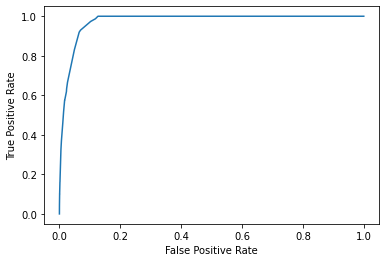

In [39]:
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay

fpr, tpr, _ = roc_curve(y_test, pred, pos_label=1)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

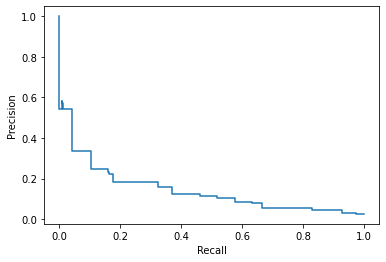

In [40]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay

prec, recall, _ = precision_recall_curve(y_test, pred, pos_label= 1)
pr_display = PrecisionRecallDisplay(precision=prec, recall=recall).plot()

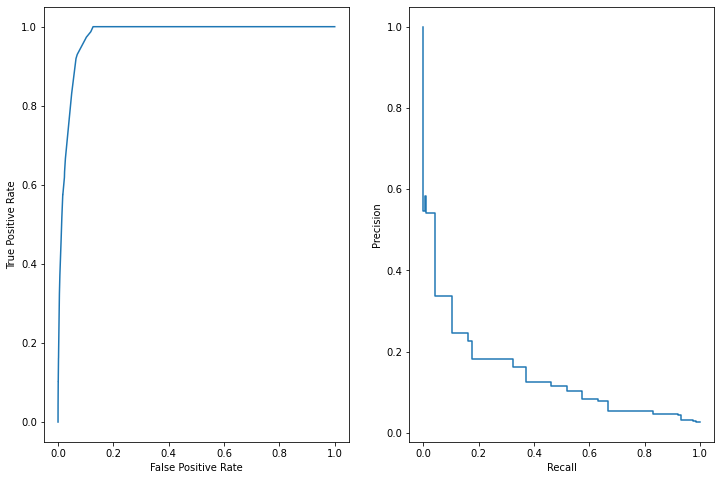

<Figure size 432x288 with 0 Axes>

In [44]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))

roc_display.plot(ax=ax1)
pr_display.plot(ax=ax2)
plt.show()
plt.savefig('auc_precision_recall.png')

## Feature Importance

In [ ]:
dt = DecisionTreeClassifier(max_depth=rs.best_params_['max_depth'])
dt.fit(X_train, y_train)
Feature_importance=pd.DataFrame([list(X_train.columns),list(dt.feature_importances_)]).T
Feature_importance.columns=["variables","importance"]

# list the top 10 most important features in order
ft= Feature_importance.sort_values(by="importance",ascending=False).iloc[:10,:]
ft

In [ ]:
plt.figure(figsize=(15, 5), dpi=80)
plt.bar(Feature_importance.sort_values(by="importance",ascending=False).iloc[:10,0],
        Feature_importance.sort_values(by="importance",ascending=False).iloc[:10,1])
plt.title("Feature Importance");

## Random Forests

In [58]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=30, n_jobs=-1,max_leaf_nodes=10)
rf.fit(X_train, y_train)
pred=rf.predict_proba(X_test)[:,1]
print(roc_auc_score(y_test,pred))

0.9713235488398778


In [59]:
param_grid = {'max_depth':range(1,50)}
rf = RandomForestClassifier(n_jobs=-1, n_estimators = 30)
gs = GridSearchCV(rf, param_grid=param_grid, scoring='roc_auc')
rs = gs.fit(X_train,y_train)
pred=rs.predict_proba(X_test)[:,1]
print(rs.best_params_)
print(roc_auc_score(np.array(y_test),pred))

{'max_depth': 9}
0.9772815668735724


In [60]:
## look at precision and recall rates
precision_recall_fscore_support(y_test, (pred > 0.5))

(array([0.99663178, 0.81818182]),
 array([0.99999126, 0.01150895]),
 array([0.99830869, 0.02269861]),
 array([228727,    782], dtype=int64))

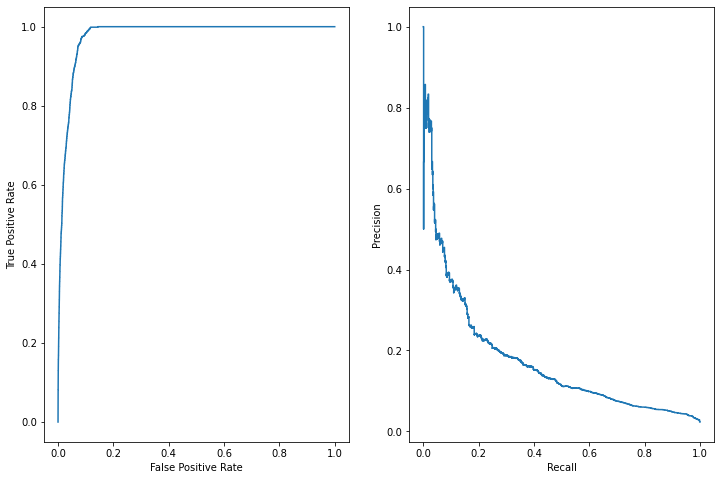

<Figure size 432x288 with 0 Axes>

In [64]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))

fpr, tpr, _ = roc_curve(y_test, pred, pos_label=1)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot(ax=ax1)

prec, recall, _ = precision_recall_curve(y_test, pred, pos_label= 1)
pr_display = PrecisionRecallDisplay(precision=prec, recall=recall).plot(ax=ax2)

plt.show()
plt.savefig('auc_precision_recall2.png')

### CMM and other ensembles

In [65]:
rf = RandomForestClassifier(n_jobs=-1, n_estimators=30, random_state = 99, max_depth = rs.best_params_['max_depth'])
rf.fit(X_train,y_train)

# randomly generate a sample of xs
X_rand= pd.DataFrame({x:X_train[x].sample(n = round(0.25*X_train.shape[0])).reset_index(drop = True) for x in X_train.columns})
y_rand= rf.predict(X_rand)

In [66]:
# create the cmm training datasets
X_train_cmm= pd.concat([X_rand, X_train], axis = 0, ignore_index = True)
y_train_cmm= pd.concat([pd.DataFrame(y_rand), y_train], axis = 0, ignore_index = True)

In [69]:
param_grid = {'max_depth':range(1,30)}
dt=DecisionTreeClassifier()
gr=GridSearchCV(dt,param_grid=param_grid, scoring='roc_auc')
rs=gr.fit(X_train,y_train)
print(rs.best_params_)
print(roc_auc_score(np.array(y_test),rs.predict_proba(X_test)[:,1]))

{'max_depth': 4}
0.9741206408332064


In [80]:
# predict_proba predicts the probability of each class rather than just the most likely class
pred=gr.predict_proba(X_test)[:,1] # predicted probability of y = 1

print("ROC AUC:", roc_auc_score(np.array(y_test),pred))
## look at precision and recall rates
pr= precision_recall_fscore_support(y_test, pred > 0.5)
print("Precision:", pr[0][1])
print("Recall:", pr[1][1])

ROC AUC: 0.9741206408332064
Precision: 0.6666666666666666
Recall: 0.0076726342710997444


# Anomaly Detection

## Isolation forests

In [113]:
from sklearn.ensemble import IsolationForest

# generate outliers
X_outliers= X.loc[X.loc[y==1].index, :]
X_reg= X.loc[X.loc[y==0].index, :]
# generate test and train data
X_train, X_test= train_test_split(X_reg, test_size=0.3, random_state=999)

# fit the model
if_clf = IsolationForest(max_samples=100, random_state=99)
if_clf.fit(X_train)
y_pred_train = if_clf.predict(X_train)
y_pred_test = if_clf.predict(X_test)
y_pred_outliers = if_clf.predict(X_outliers)

In [114]:
print("Percent training classified as inliers:", np.mean(y_pred_train==1))
print("Percent test data classified as inliers:", np.mean(y_pred_test==1))
print("Percent outliers classified as inliers:", np.mean(y_pred_outliers==1))

Percent training classified as inliers: 0.913049751169205
Percent test data classified as inliers: 0.9122101360568011
Percent outliers classified as inliers: 0.2434715821812596


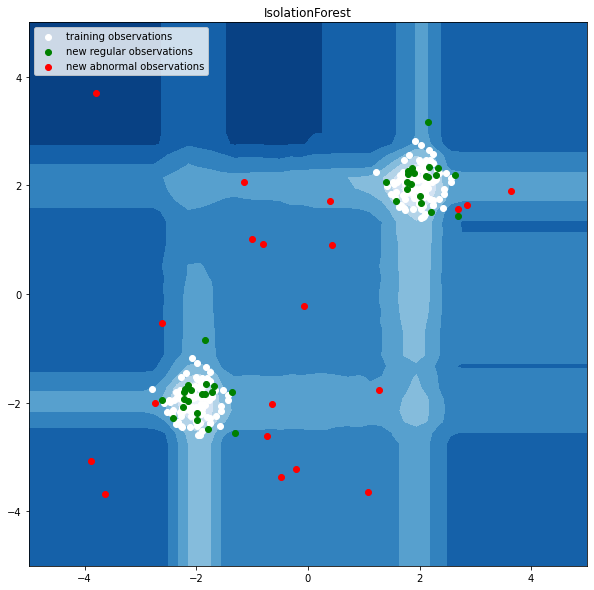

In [95]:
rng = np.random.RandomState(42)

# Generate train data
X = 0.3 * rng.randn(100, 2)
X_train = np.r_[X + 2, X - 2]
# Generate some regular novel observations
X = 0.3 * rng.randn(20, 2)
X_test = np.r_[X + 2, X - 2]
# Generate some abnormal novel observations
X_outliers = rng.uniform(low=-4, high=4, size=(20, 2))

# fit the model
clf = IsolationForest(max_samples=100, random_state=rng)
clf.fit(X_train)
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)
y_pred_outliers = clf.predict(X_outliers)

# plot the line, the samples, and the nearest vectors to the plane
xx, yy = np.meshgrid(np.linspace(-5, 5, 50), np.linspace(-5, 5, 50))
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(10,10))

plt.title("IsolationForest")
plt.contourf(xx, yy, Z, cmap=plt.cm.Blues_r)

b1 = plt.scatter(X_train[:, 0], X_train[:, 1], c='white')
b2 = plt.scatter(X_test[:, 0], X_test[:, 1], c='green')
c = plt.scatter(X_outliers[:, 0], X_outliers[:, 1], c='red')
plt.axis('tight')
plt.xlim((-5, 5))
plt.ylim((-5, 5))
plt.legend([b1, b2, c],
           ["training observations",
            "new regular observations", "new abnormal observations"],
           loc="upper left")
plt.show()